In [1]:
import numpy as np
from scipy.io import loadmat
from matplotlib.animation import FuncAnimation
from matplotlib import pyplot as plt
import skimage as sk
import pandas as pd
import time
from mpl_toolkits.mplot3d import Axes3D
import scipy as sp

## LAB 5

In [2]:
T1 = 400*10**-3 #s
T2 = 40*10**-3 #s
TE = 10*10**-3 #s
TR = 100*10**-3 #s
step = 0.5*10**-3 #s

Spin Echo sequence is based on repetition of 90° and 180° RF pulses. Spin Echo sequence has two parameters:

 - Echo Time (TE) is the time between the 90° RF pulse and MR signal sampling, corresponding to maximum of echo. The 180° RF pulse is applied at time TE/2.
 - Repetition Time (TR) is the time between 2 excitations pulses (time between two 90° RF pulses)

Considering **on-ressonance** spins:

### **Question 1**

Simulate the evolution of the magnetization during one TR and plot each
magnetization component as a function of time.

In [3]:
#90 deg excitation along x
rotation_matrix = np.array([[1,0,0],
                          [0,np.cos(np.pi/2),np.sin(np.pi/2)],
                          [0,-np.sin(np.pi/2),np.cos(np.pi/2)]])

#180 deg refocuse along x
refocus_matrix = np.array([[1,0,0],
                          [0,np.cos(np.pi),np.sin(np.pi)],
                          [0,-np.sin(np.pi),np.cos(np.pi)]])

relax_matrix = np.array([[np.exp(-step/T2), 0, 0],
                         [0, np.exp(-step/T2), 0],
                         [0, 0, np.exp(-step/T1)]]) #relaxation matrix

M0 = np.array([0,0,1]) #initial magnetization vector

M = np.dot(rotation_matrix, M0.transpose()).reshape(3,1) #magnetization vector


for i in np.arange(step, TR, step):
    if round(i,4) == TE/2:
        M = np.append(M, np.dot(relax_matrix, np.array([M[:,-1]]).transpose()) + np.array([[0,0,(1-np.exp(-step/T1))]]).transpose(),axis=1)
        M[:,-1] = np.dot(refocus_matrix,M[:,-1].transpose())
    else:
        M = np.append(M, np.dot(relax_matrix, np.array([M[:,-1]]).transpose()) + np.array([[0,0,(1-np.exp(-step/T1))]]).transpose(),axis=1)



In [4]:
TR_vec = np.array([np.arange(0, TR, step)])

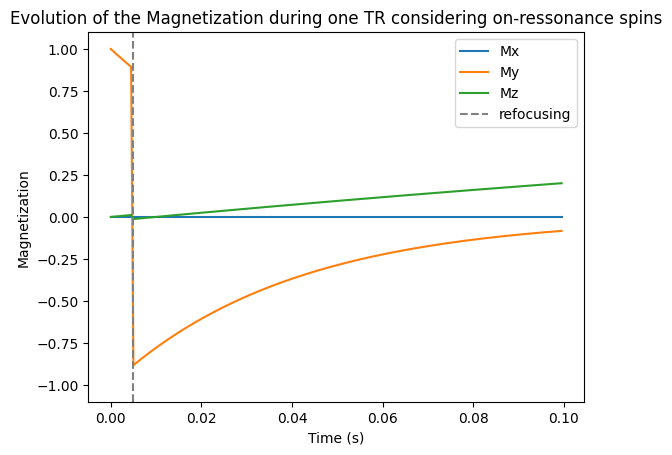

In [5]:
plt.figure()

plt.plot(TR_vec[0], np.array([M[0,:]])[0], label='Mx')
plt.plot(TR_vec[0], np.array([M[1,:]])[0], label='My')
plt.plot(TR_vec[0], np.array([M[2,:]])[0], label='Mz')
#plt.plot(TR_vec[0],np.exp(-TR_vec[0]/T2), label='T2 decay', linestyle='dashed', color = "black")
#plt.plot(TR_vec[0],-1*np.exp(-TR_vec[0]/T2), linestyle='dashed', color = "black")
plt.xlabel("Time (s)")
plt.ylabel("Magnetization")
#ax2.plot(t[0], np.array([Mnet[0]])[0],  label='|M|')
plt.xlabel("Time (s)")
#ax2.set_ylabel("Magnetization (M)")
#ax2.set_title("Evolution of the magnetization vector and tip angle during excitation by a 90º RF pulse")
#.plot(t[0], np.array([angle[0]])[0],  label='tip angle', linestyle='dashed', color = "black")
#ax21.set_ylabel("Tip angle (deg)")
plt.title("Evolution of the Magnetization during one TR considering on-ressonance spins")
plt.axvline(TE/2, linestyle = "dashed", color = "grey", label = "refocusing")
plt.ylim([-1.10, 1.10])
#plt.xticks(np.arange(0, TR, step=TE/2))
plt.legend(loc='upper right')
plt.show()

After a 90° RF pulse, net magnetization tips down so that longitudinal magnetization has disappeared and transverse magnetization has appeared. Once the RF transmitter is turned off, relaxation happens: transverse magnetization decays according to an exponential curve characterized by time constant T2 and longitudinal magnetization recovers. After a 90° RF pulse, spins dephase and transverse magnetization decreases. If we apply a 180° RF pulse, spins rephase and transverse magnetization reappears.

### **Question 2**

Compute the complex transverse magnetization, and plot its amplitude and phase as a function of time.

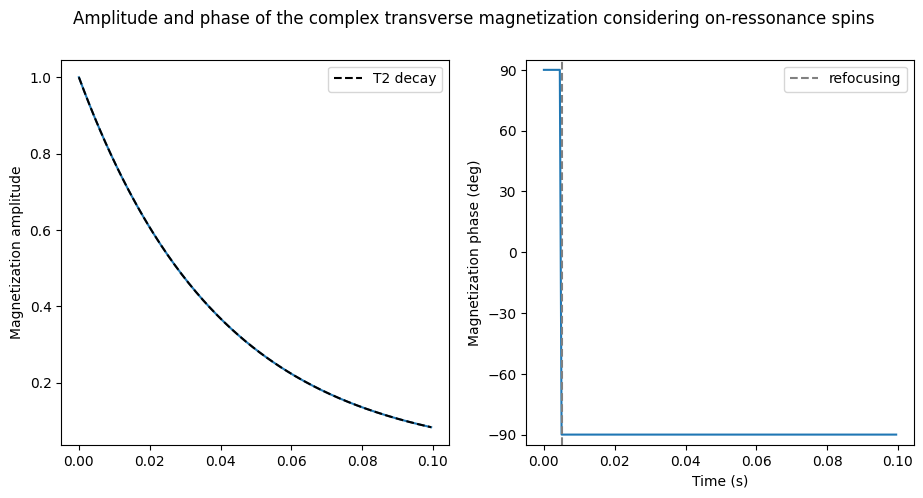

In [9]:
# transverse magnetization

Mxy = np.array([M[0,:] + 1j*M[1,:]])

# plot angle and magnitude in function of time

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))
fig.suptitle("Amplitude and phase of the complex transverse magnetization considering on-ressonance spins")
ax1.plot(TR_vec[0], np.abs(Mxy[0]))
ax1.set_ylabel("Magnetization amplitude")
ax1.plot(TR_vec[0],np.exp(-TR_vec[0]/T2), label='T2 decay', linestyle='dashed', color = "black")
ax1.legend()
#ax2.plot(TR_vec[0], np.angle(Mxy[0])*(180/np.pi), label='angle(Mxy)')
ax2.plot(TR_vec[0], np.angle(Mxy[0])*(180/np.pi))
ax2.set_ylabel("Magnetization phase (deg)")
ax2.set_xlabel("Time (s)")
ax2.set_ylim([-95, 95])
ax2.set_yticks(np.arange(-90, 100, step=30))
ax2.axvline(TE/2, linestyle = "dashed", color = "grey", label = "refocusing")
ax2.legend()
plt.show()



The transverse magnetization's amplitude is decaying, T2 relaxation causes dephasing of the magnetization in the xy-plane, resulting in a decrease in transverse magnetization magnitude. The transverse magnetization's phase is initially 90 degrees, meaning that the magnetization vector is fully aligned along the y-axis in the xy-plane. After a 180-degree refocusing pulse, the phase of the complex transverse magnetization is inverted. As the magnetization was originally along the y-axis after the 90-degree excitation pulse, the 180-degree refocusing pulse will flip it across the x-axis to be along the negative y-axis. In the absence of significant off-resonance effects, the angle of the transverse magnetization will remain relatively constant becuase the spins experience the same precessional motion around the magnetic field axis,so the phase relationship between them remains constant.

### **Question 3**

Now consider an ensemble of **off-resonance** spins with Δω between -60 and +60 Hz, in steps of 1 Hz:

Repeat 1. and 2.; for the plots, consider the average magnetization of all spins.

In [10]:
off_r = np.arange(-60,61,1)*np.pi*2

In [11]:
M_off = np.zeros((3,200,121))

for i in range(len(off_r)):
    #rotation_matrix_off = np.array([[1,0,0],
                            #[0,np.cos(off_r[i]*step),np.sin(off_r[i]*step)],
                            #[0,-np.sin(off_r[i]*step),np.cos(off_r[i]*step)]])
            
    rotation_matrix_off = np.array([[np.cos(off_r[i]*step), np.sin(off_r[i]*step),0],
                            [-np.sin(off_r[i]*step), np.cos(off_r[i]*step),0],
                            [0,0, 1]])
    M_off[:,0,i] = np.array([0,1,0]) # primeira entrada: magnitude, segunda entrada: tempo, terceira entrada: freq
    for j in range(1,int(TR/step),1):
        if j == (TE/2)/step:
            M_off[:,j,i:i+1] = np.dot(relax_matrix, np.array([M_off[:,j-1,i]]).transpose()) + np.array([[0,0,(1-np.exp(-step/T1))]]).transpose()
            M_off[:,j,i:i+1] = np.dot(rotation_matrix_off,np.array([M_off[:,j,i]]).transpose())
            M_off[:,j,i:i+1] = np.dot(refocus_matrix,np.array([M_off[:,j,i]]).transpose())
        else:
            M_off[:,j,i:i+1] = np.dot(relax_matrix, np.array([M_off[:,j-1,i]]).transpose()) + np.array([[0,0,(1-np.exp(-step/T1))]]).transpose()
            M_off[:,j,i:i+1] = np.dot(rotation_matrix_off,np.array([M_off[:,j,i]]).transpose())



In [12]:
# get averages
M_avg = np.zeros((3,200))

M_avg[0,:] = np.sum(M_off[0,:,:],axis=1)/len(off_r)
M_avg[1,:] = np.sum(M_off[1,:,:],axis=1)/len(off_r)
M_avg[2,:] = np.sum(M_off[2,:,:],axis=1)/len(off_r)

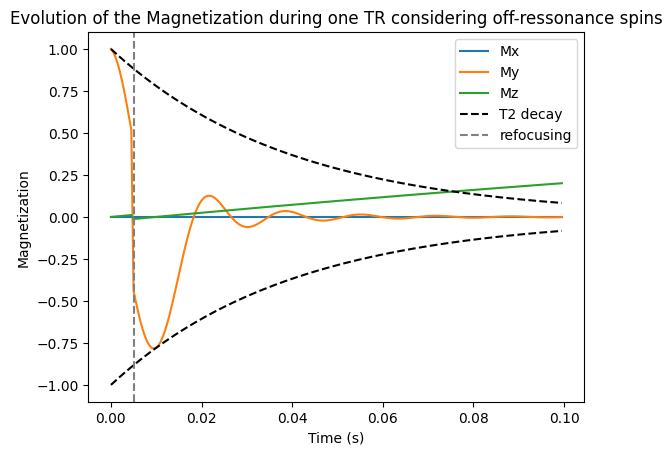

In [13]:
plt.figure()
plt.plot(TR_vec[0], M_avg[0,:], label='Mx')
plt.plot(TR_vec[0], M_avg[1,:], label='My')
plt.plot(TR_vec[0], M_avg[2,:], label='Mz')
plt.plot(TR_vec[0],np.exp(-TR_vec[0]/T2), label='T2 decay', linestyle='dashed', color = "black")
plt.plot(TR_vec[0],-1*np.exp(-TR_vec[0]/T2), linestyle='dashed', color = "black")
plt.xlabel("Time (s)")
plt.ylabel("Magnetization")
plt.title("Evolution of the Magnetization during one TR considering off-ressonance spins")
plt.axvline(TE/2, linestyle = "dashed", color = "grey", label = "refocusing")
plt.ylim([-1.10, 1.10])
plt.legend(loc='upper right')
plt.show()

At the start of the TR, a 90 degree radiofrequency (RF) excitation pulse is applied along the +x axis. This pulse tips the magnetization from its equilibrium state (along the z-axis) to the transverse plane (xy-plane) and aligns it with the +y-axis. After excitation, the transverse magnetization starts decaying while the longitudinal magnetization increases. To counteract the effects of T2 relaxation and off-resonance, refocusing pulses, such as a 180-degree pulse along the +x axis, are applied during the TR. This pulse flips the transverse magnetization to -y-axis. These pulses help reverse the phase dispersion caused by off-resonance spins and refocus the magnetization, enhancing signal coherence.

In [14]:
M_off_2 = np.zeros((3,200,121))

for i in range(len(off_r)):
    #rotation_matrix_off = np.array([[1,0,0],
                            #[0,np.cos(off_r[i]*step),np.sin(off_r[i]*step)],
                            #[0,-np.sin(off_r[i]*step),np.cos(off_r[i]*step)]])
            
    rotation_matrix_off = np.array([[np.cos(off_r[i]*step), np.sin(off_r[i]*step),0],
                            [-np.sin(off_r[i]*step), np.cos(off_r[i]*step),0],
                            [0,0, 1]])
    M_off_2[:,0,i] = np.array([0,1,0]) # primeira entrada: magnitude, segunda entrada: tempo, terceira entrada: freq
    for j in range(1,int(TR/step),1):
        if j == (TE/2)/step:
            M_off_2[:,j,i:i+1] = np.dot(relax_matrix, np.array([M_off_2[:,j-1,i]]).transpose()) + np.array([[0,0,(1-np.exp(-step/T1))]]).transpose()
            M_off_2[:,j,i:i+1] = np.dot(rotation_matrix_off,np.array([M_off_2[:,j,i]]).transpose())
            #M_off[:,j,i:i+1] = np.dot(refocus_matrix,np.array([M_off[:,j,i]]).transpose())
        else:
            M_off_2[:,j,i:i+1] = np.dot(relax_matrix, np.array([M_off_2[:,j-1,i]]).transpose()) + np.array([[0,0,(1-np.exp(-step/T1))]]).transpose()
            M_off_2[:,j,i:i+1] = np.dot(rotation_matrix_off,np.array([M_off_2[:,j,i]]).transpose())



In [15]:
# get averages
M_avg2 = np.zeros((3,200))

M_avg2[0,:] = np.sum(M_off_2[0,:,:],axis=1)/len(off_r)
M_avg2[1,:] = np.sum(M_off_2[1,:,:],axis=1)/len(off_r)
M_avg2[2,:] = np.sum(M_off_2[2,:,:],axis=1)/len(off_r)

<Figure size 640x480 with 0 Axes>

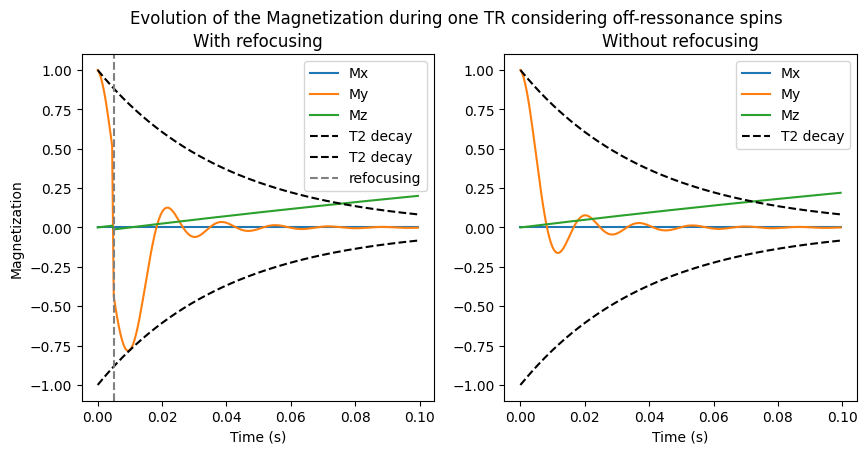

In [16]:
plt.figure()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.5))
fig.suptitle("Evolution of the Magnetization during one TR considering off-ressonance spins")
ax1.plot(TR_vec[0], M_avg[0,:], label='Mx')
ax1.plot(TR_vec[0], M_avg[1,:], label='My')
ax1.plot(TR_vec[0], M_avg[2,:], label='Mz')
ax1.plot(TR_vec[0],np.exp(-TR_vec[0]/T2), label='T2 decay', linestyle='dashed', color = "black")
ax1.plot(TR_vec[0],-1*np.exp(-TR_vec[0]/T2), label='T2 decay', linestyle='dashed', color = "black")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Magnetization")
ax1.title.set_text('With refocusing')
ax1.axvline(TE/2, linestyle = "dashed", color = "grey", label = "refocusing")
ax1.set_ylim([-1.10, 1.10])
ax1.legend(loc='upper right')
ax2.plot(TR_vec[0], M_avg2[0,:], label='Mx')
ax2.plot(TR_vec[0], M_avg2[1,:], label='My')
ax2.plot(TR_vec[0], M_avg2[2,:], label='Mz')
ax2.plot(TR_vec[0],np.exp(-TR_vec[0]/T2), label='T2 decay', linestyle='dashed', color = "black")
ax2.plot(TR_vec[0],-1*np.exp(-TR_vec[0]/T2), linestyle='dashed', color = "black")
ax2.set_xlabel("Time (s)")
#ax2.set_ylabel("Magnetization")
ax2.title.set_text('Without refocusing')
#plt.axvline(TE/2, linestyle = "dashed", color = "grey", label = "refocusing")
ax2.set_ylim([-1.10, 1.10])
ax2.legend(loc='upper right')

The refocusing slows down the decay rate. Refocusing is necessary to preserve the signal.

<Figure size 640x480 with 0 Axes>

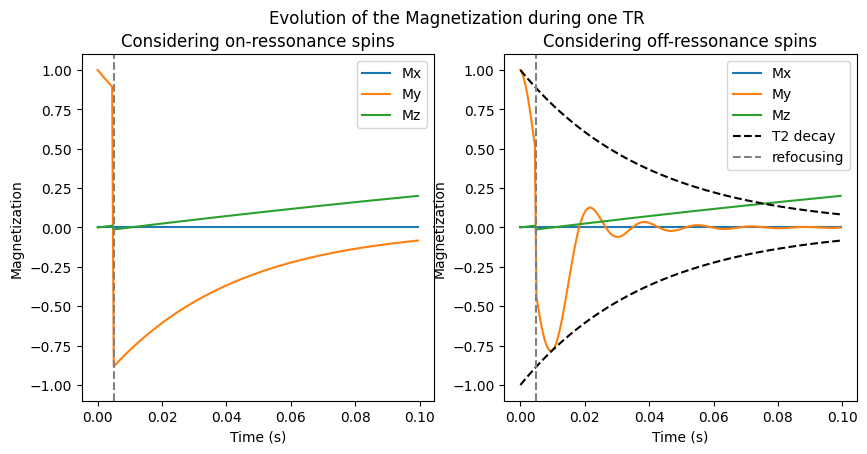

In [17]:
plt.figure()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.5))
fig.suptitle("Evolution of the Magnetization during one TR")
ax1.plot(TR_vec[0], np.array([M[0,:]])[0], label='Mx')
ax1.plot(TR_vec[0], np.array([M[1,:]])[0], label='My')
ax1.plot(TR_vec[0], np.array([M[2,:]])[0], label='Mz')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Magnetization")
ax1.legend(loc='upper right')
#ax2.plot(t[0], np.array([Mnet[0]])[0],  label='|M|')
#ax2.set_ylabel("Magnetization (M)")
#ax2.set_title("Evolution of the magnetization vector and tip angle during excitation by a 90º RF pulse")
#.plot(t[0], np.array([angle[0]])[0],  label='tip angle', linestyle='dashed', color = "black")
#ax21.set_ylabel("Tip angle (deg)")
ax1.title.set_text("Considering on-ressonance spins")
ax1.axvline(TE/2, linestyle = "dashed", color = "grey", label = "TE/2")
ax1.set_ylim([-1.10, 1.10])
#plt.xticks(np.arange(0, TR, step=TE/2))
ax2.title.set_text("Considering off-ressonance spins")
ax2.plot(TR_vec[0], M_avg[0,:], label='Mx')
ax2.plot(TR_vec[0], M_avg[1,:], label='My')
ax2.plot(TR_vec[0], M_avg[2,:], label='Mz')
ax2.plot(TR_vec[0],np.exp(-TR_vec[0]/T2), label='T2 decay', linestyle='dashed', color = "black")
ax2.plot(TR_vec[0],-1*np.exp(-TR_vec[0]/T2), linestyle='dashed', color = "black")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Magnetization")
ax2.title.set_text("Considering off-ressonance spins")
ax2.axvline(TE/2, linestyle = "dashed", color = "grey", label = "refocusing")
ax2.set_ylim([-1.10, 1.10])
ax2.legend(loc='upper right')


Off-resonance T2 decay typically occurs at a faster rate compared to on-resonance decay.

The T2 decay profile in the presence of off-resonance effects can be influenced by the specific distribution of off-resonance frequencies. Spins experiencing higher off-resonance frequencies may decay faster compared to those closer to the Larmor frequency. The greater the frequency difference between the off-resonance spins and the Larmor frequency, the faster the decay rate.

In [18]:
M_off_60 = np.zeros((3,200))
rotation_matrix_off = np.array([[np.cos(60*np.pi*2*step), np.sin(60*np.pi*2*step),0],
                        [-np.sin(60*np.pi*2*step), np.cos(60*np.pi*2*step),0],
                        [0,0, 1]])
M_off_60[:,0] = np.array([0,1,0]) # primeira entrada: magnitude, segunda entrada: tempo, terceira entrada: freq
for j in range(1,int(TR/step),1):
    if j == (TE/2)/step:
        M_off_60[:,j:j+1] = np.dot(relax_matrix, np.array([M_off_60[:,j-1]]).transpose()) + np.array([[0,0,(1-np.exp(-step/T1))]]).transpose()
        M_off_60[:,j:j+1] = np.dot(rotation_matrix_off,np.array([M_off_60[:,j]]).transpose())
        M_off_60[:,j:j+1] = np.dot(refocus_matrix,np.array([M_off_60[:,j]]).transpose())
    else:
        M_off_60[:,j:j+1] = np.dot(relax_matrix, np.array([M_off_60[:,j-1]]).transpose()) + np.array([[0,0,(1-np.exp(-step/T1))]]).transpose()
        M_off_60[:,j:j+1] = np.dot(rotation_matrix_off,np.array([M_off_60[:,j]]).transpose())

In [19]:
M_off_60_m = np.zeros((3,200))
rotation_matrix_off = np.array([[np.cos(-60*np.pi*2*step), np.sin(-60*np.pi*2*step),0],
                        [-np.sin(-60*np.pi*2*step), np.cos(-60*np.pi*2*step),0],
                        [0,0, 1]])
M_off_60_m[:,0] = np.array([0,1,0]) # primeira entrada: magnitude, segunda entrada: tempo, terceira entrada: freq
for j in range(1,int(TR/step),1):
    if j == (TE/2)/step:
        M_off_60_m[:,j:j+1] = np.dot(relax_matrix, np.array([M_off_60_m[:,j-1]]).transpose()) + np.array([[0,0,(1-np.exp(-step/T1))]]).transpose()
        M_off_60_m[:,j:j+1] = np.dot(rotation_matrix_off,np.array([M_off_60_m[:,j]]).transpose())
        M_off_60_m[:,j:j+1] = np.dot(refocus_matrix,np.array([M_off_60_m[:,j]]).transpose())
    else:
        M_off_60_m[:,j:j+1] = np.dot(relax_matrix, np.array([M_off_60_m[:,j-1]]).transpose()) + np.array([[0,0,(1-np.exp(-step/T1))]]).transpose()
        M_off_60_m[:,j:j+1] = np.dot(rotation_matrix_off,np.array([M_off_60_m[:,j]]).transpose())

<Figure size 640x480 with 0 Axes>

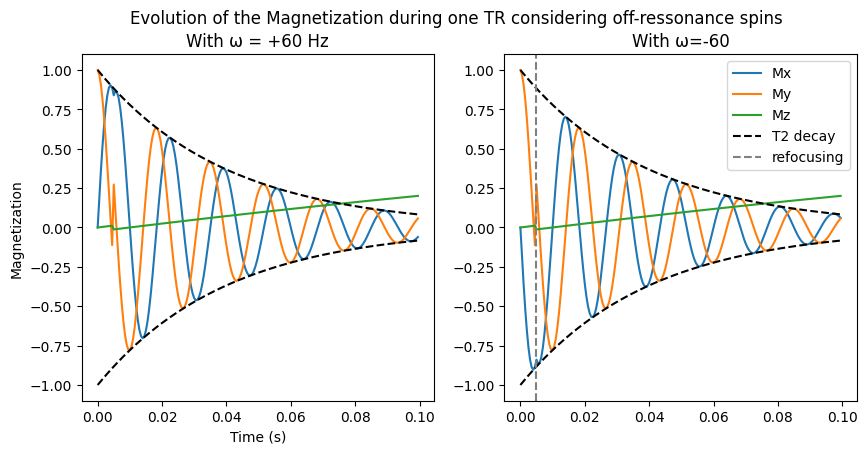

In [20]:
plt.figure()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.5))
fig.suptitle("Evolution of the Magnetization during one TR considering off-ressonance spins")
ax1.plot(TR_vec[0], np.array([M_off_60[0,:]])[0], label='Mx')
ax1.plot(TR_vec[0], np.array([M_off_60[1,:]])[0], label='My')
ax1.plot(TR_vec[0], np.array([M_off_60[2,:]])[0], label='Mz')
ax1.plot(TR_vec[0],np.exp(-TR_vec[0]/T2), label='T2 decay', linestyle='dashed', color = "black")
ax1.plot(TR_vec[0],-1*np.exp(-TR_vec[0]/T2), linestyle='dashed', color = "black")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Magnetization")
ax1.title.set_text('With ω = +60 Hz')
ax2.plot(TR_vec[0], np.array([M_off_60_m[0,:]])[0], label='Mx')
ax2.plot(TR_vec[0], np.array([M_off_60_m[1,:]])[0], label='My')
ax2.plot(TR_vec[0], np.array([M_off_60_m[2,:]])[0], label='Mz')
ax2.plot(TR_vec[0],np.exp(-TR_vec[0]/T2), label='T2 decay', linestyle='dashed', color = "black")
ax2.plot(TR_vec[0],-1*np.exp(-TR_vec[0]/T2), linestyle='dashed', color = "black")
#ax2.set_title.text("Evolution of the Magnetization during one TR considering off-ressonance spins")
ax2.axvline(TE/2, linestyle = "dashed", color = "grey", label = "refocusing")
ax2.set_ylim([-1.10, 1.10])
ax2.title.set_text('With ω=-60')
#plt.xticks(np.arange(0, TR, step=TE/2))
ax2.legend(loc='upper right')

In [21]:
off_r_20 = np.arange(-20,21,1)*np.pi*2

In [22]:
M_off_20 = np.zeros((3,200,41))

for i in range(len(off_r_20)):
    #rotation_matrix_off = np.array([[1,0,0],
                            #[0,np.cos(off_r[i]*step),np.sin(off_r[i]*step)],
                            #[0,-np.sin(off_r[i]*step),np.cos(off_r[i]*step)]])
            
    rotation_matrix_off = np.array([[np.cos(off_r_20[i]*step), np.sin(off_r_20[i]*step),0],
                            [-np.sin(off_r_20[i]*step), np.cos(off_r_20[i]*step),0],
                            [0,0, 1]])
    M_off_20[:,0,i] = np.array([0,1,0]) # primeira entrada: magnitude, segunda entrada: tempo, terceira entrada: freq
    for j in range(1,int(TR/step),1):
        if j == (TE/2)/step:
            M_off_20[:,j,i:i+1] = np.dot(relax_matrix, np.array([M_off_20[:,j-1,i]]).transpose()) + np.array([[0,0,(1-np.exp(-step/T1))]]).transpose()
            M_off_20[:,j,i:i+1] = np.dot(rotation_matrix_off,np.array([M_off_20[:,j,i]]).transpose())
            M_off_20[:,j,i:i+1] = np.dot(refocus_matrix,np.array([M_off_20[:,j,i]]).transpose())
        else:
            M_off_20[:,j,i:i+1] = np.dot(relax_matrix, np.array([M_off_20[:,j-1,i]]).transpose()) + np.array([[0,0,(1-np.exp(-step/T1))]]).transpose()
            M_off_20[:,j,i:i+1] = np.dot(rotation_matrix_off,np.array([M_off_20[:,j,i]]).transpose())



In [23]:
M_avg_20 = np.zeros((3,200))

M_avg_20[0,:] = np.sum(M_off_20[0,:,:],axis=1)/len(off_r_20)
M_avg_20[1,:] = np.sum(M_off_20[1,:,:],axis=1)/len(off_r_20)
M_avg_20[2,:] = np.sum(M_off_20[2,:,:],axis=1)/len(off_r_20)

<Figure size 640x480 with 0 Axes>

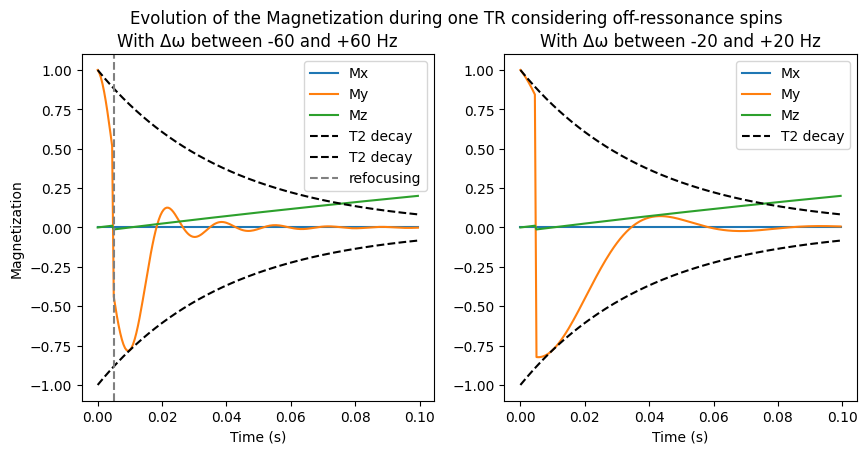

In [24]:
plt.figure()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.5))
fig.suptitle("Evolution of the Magnetization during one TR considering off-ressonance spins")
ax1.plot(TR_vec[0], M_avg[0,:], label='Mx')
ax1.plot(TR_vec[0], M_avg[1,:], label='My')
ax1.plot(TR_vec[0], M_avg[2,:], label='Mz')
ax1.plot(TR_vec[0],np.exp(-TR_vec[0]/T2), label='T2 decay', linestyle='dashed', color = "black")
ax1.plot(TR_vec[0],-1*np.exp(-TR_vec[0]/T2), label='T2 decay', linestyle='dashed', color = "black")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Magnetization")
ax1.title.set_text('With Δω between -60 and +60 Hz')
ax1.axvline(TE/2, linestyle = "dashed", color = "grey", label = "refocusing")
ax1.set_ylim([-1.10, 1.10])
ax1.legend(loc='upper right')
ax2.plot(TR_vec[0], M_avg_20[0,:], label='Mx')
ax2.plot(TR_vec[0], M_avg_20[1,:], label='My')
ax2.plot(TR_vec[0], M_avg_20[2,:], label='Mz')
ax2.plot(TR_vec[0],np.exp(-TR_vec[0]/T2), label='T2 decay', linestyle='dashed', color = "black")
ax2.plot(TR_vec[0],-1*np.exp(-TR_vec[0]/T2), linestyle='dashed', color = "black")
ax2.set_xlabel("Time (s)")
#ax2.set_ylabel("Magnetization")
ax2.title.set_text('With Δω between -20 and +20 Hz')
#plt.axvline(TE/2, linestyle = "dashed", color = "grey", label = "refocusing")
ax2.set_ylim([-1.10, 1.10])
ax2.legend(loc='upper right')

With a smaller off-ressonance range, the decay is slower. The more off-ressonance the spins are, the faster the decay is. 

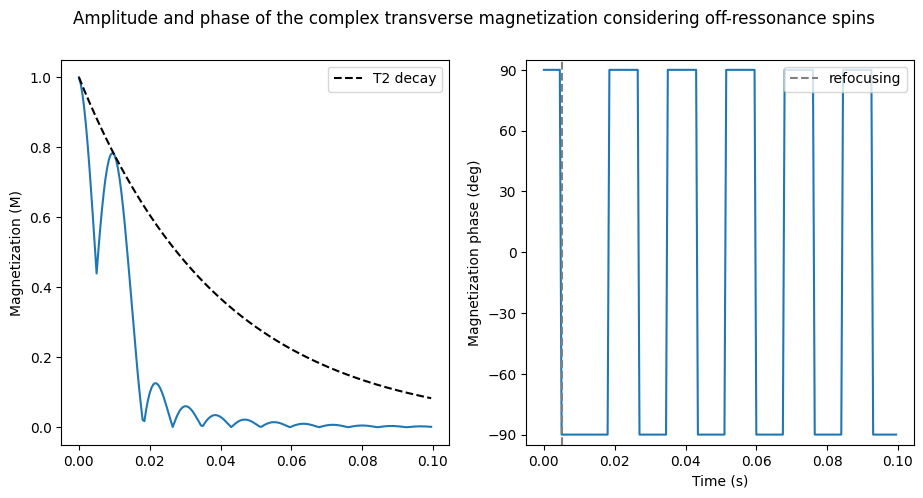

In [25]:
# transverse magnetization 
M_xy_avg = np.array([M_avg[0,:] + 1j*M_avg[1,:]])
# plot angle and magnitude in function of time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))
ax1.plot(TR_vec[0], np.abs(M_xy_avg[0]))
ax1.set_ylabel("Magnetization (M)")
ax1.plot(TR_vec[0],np.exp(-TR_vec[0]/T2), label='T2 decay', linestyle='dashed', color = "black")
ax1.legend()
ax2.plot(TR_vec[0], np.angle(M_xy_avg[0])*(180/np.pi))
ax2.set_ylabel("Magnetization phase (deg)")
ax2.set_xlabel("Time (s)")
ax2.set_ylim([-95, 95])
fig.suptitle("Amplitude and phase of the complex transverse magnetization considering off-ressonance spins")
ax2.axvline(TE/2, linestyle = "dashed", color = "grey", label = "refocusing")
ax2.legend(loc='upper right')
ax2.set_yticks(np.arange(-90, 100, step=30))
plt.show()



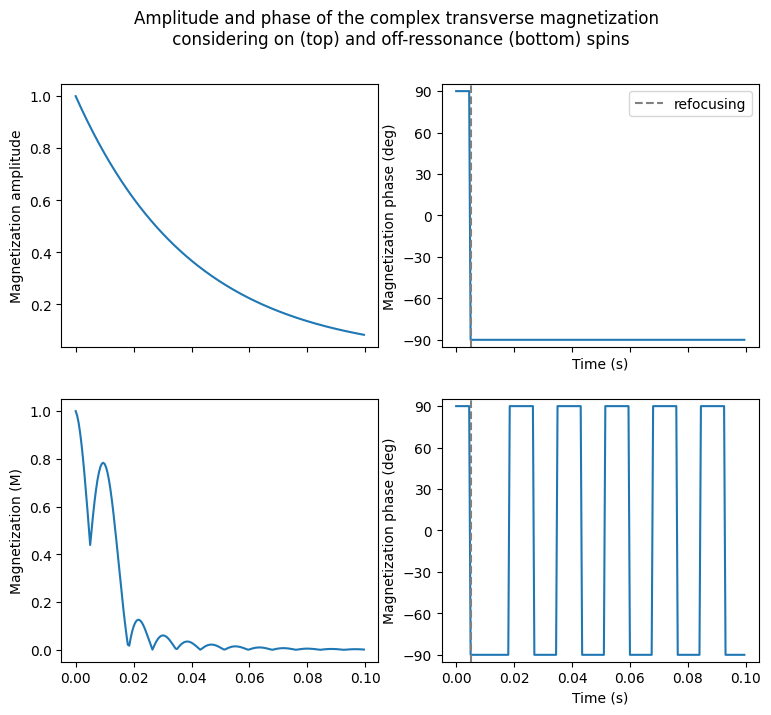

In [26]:
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(9,7.5))
fig.suptitle("Amplitude and phase of the complex transverse magnetization \n considering on (top) and off-ressonance (bottom) spins")
axs[0,0].plot(TR_vec[0], np.abs(Mxy[0]), label='|Mxy|')
axs[0,0].set_ylabel("Magnetization amplitude")
#ax2.plot(TR_vec[0], np.angle(Mxy[0])*(180/np.pi), label='angle(Mxy)')
axs[0,1].plot(TR_vec[0], np.angle(Mxy[0])*(180/np.pi))
axs[0,1].set_ylabel("Magnetization phase (deg)")
axs[0,1].set_xlabel("Time (s)")
axs[0,1].set_ylim([-95, 95])
axs[0,1].set_yticks(np.arange(-90, 100, step=30))
axs[0,1].axvline(TE/2, linestyle = "dashed", color = "grey", label = "refocusing")
axs[0,1].legend()
axs[1,0].plot(TR_vec[0], np.abs(M_xy_avg[0]), label='|Mxy|')
axs[1,0].set_ylabel("Magnetization (M)")
axs[1,1].plot(TR_vec[0], np.angle(M_xy_avg[0])*(180/np.pi), label='angle(Mxy)')
axs[1,1].set_ylabel("Magnetization phase (deg)")
axs[1,1].set_xlabel("Time (s)")
axs[1,1].set_ylim([-95, 95])
axs[1,1].axvline(TE/2, linestyle = "dashed", color = "grey", label = "refocusing")
axs[1,1].set_yticks(np.arange(-90, 100, step=30))

Off-resonance spins precess at different frequencies, causing a phase dispersion in the transverse magnetization across the sample.This phase dispersion results in a varying angle of the transverse magnetization across the sample.

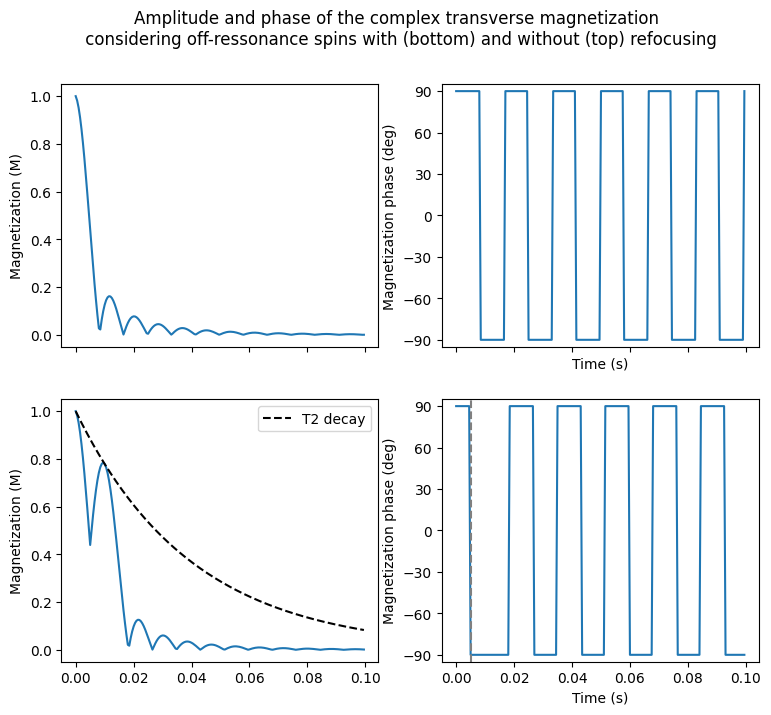

In [41]:
M_xy_avg_2 = np.array([M_avg2[0,:] + 1j*M_avg2[1,:]])
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(9,7.5))
fig.suptitle("Amplitude and phase of the complex transverse magnetization \n considering off-ressonance spins with (bottom) and without (top) refocusing")
axs[0,0].plot(TR_vec[0], np.abs(M_xy_avg_2[0]), label='|Mxy|')
axs[0,0].set_ylabel("Magnetization (M)")
axs[0,1].plot(TR_vec[0], np.angle(M_xy_avg_2[0])*(180/np.pi), label='angle(Mxy)')
axs[0,1].set_ylabel("Magnetization phase (deg)")
axs[0,1].set_xlabel("Time (s)")
axs[0,1].set_ylim([-95, 95])
axs[1,0].plot(TR_vec[0], np.abs(M_xy_avg[0]))
axs[1,0].set_ylabel("Magnetization (M)")
axs[1,1].plot(TR_vec[0], np.angle(M_xy_avg[0])*(180/np.pi), label='angle(Mxy)')
axs[1,1].set_ylabel("Magnetization phase (deg)")
axs[1,1].set_xlabel("Time (s)")
axs[1,1].set_ylim([-95, 95])
axs[1,1].axvline(TE/2, linestyle = "dashed", color = "grey", label = "refocusing")
axs[1,0].plot(TR_vec[0],np.exp(-TR_vec[0]/T2), label='T2 decay', linestyle='dashed', color = "black")
axs[1,0].legend()
axs[0,1].set_yticks(np.arange(-90, 100, step=30))
axs[1,1].set_yticks(np.arange(-90, 100, step=30))

### **Question 4**

Repeat 3. for a multiple spin-echo experiment with 8 echoes and determine the T2 of
the sample using the data measured in this experiment.

In [28]:
M_off_echo = np.zeros((3,200,121))
TR8_vec= np.array([np.arange(0, TR*8, step)])
for i in range(len(off_r)):
    #rotation_matrix_off = np.array([[1,0,0],
                            #[0,np.cos(off_r[i]*step),np.sin(off_r[i]*step)],
                            #[0,-np.sin(off_r[i]*step),np.cos(off_r[i]*step)]])
    rotation_matrix_off= np.array([[np.cos(off_r[i]*step), np.sin(off_r[i]*step),0],
                            [-np.sin(off_r[i]*step), np.cos(off_r[i]*step),0],
                            [0,0, 1]])
    M_off_echo[:,0,i] = np.array([0,1,0]) # primeira entrada: magnitude, segunda entrada: tempo, terceira entrada: freq
    for j in range(1,int(TR/step),1):
        if j == (TE/2)/step or j == (TE*(3/2))/step or j == (TE*(5/2))/step or j == (TE*(7/2))/step or j == (TE*(9/2))/step or j == (TE*(11/2))/step or j == (TE*(13/2))/step or j == (TE*(15/2))/step:
            M_off_echo[:,j,i:i+1] = np.dot(relax_matrix, np.array([M_off_echo[:,j-1,i]]).transpose()) + np.array([[0,0,(1-np.exp(-step/T1))]]).transpose()
            M_off_echo[:,j,i:i+1] = np.dot(rotation_matrix_off,np.array([M_off_echo[:,j,i]]).transpose())
            M_off_echo[:,j,i:i+1] = np.dot(refocus_matrix,np.array([M_off_echo[:,j,i]]).transpose())
        else:
            M_off_echo[:,j,i:i+1] = np.dot(relax_matrix, np.array([M_off_echo[:,j-1,i]]).transpose()) + np.array([[0,0,(1-np.exp(-step/T1))]]).transpose()
            M_off_echo[:,j,i:i+1] = np.dot(rotation_matrix_off,np.array([M_off_echo[:,j,i]]).transpose())

In [29]:
# get averages

M_avg_echo = np.zeros((3,200))

M_avg_echo[0,:] = np.sum(M_off_echo[0,:,:],axis=1)/len(off_r)
M_avg_echo[1,:] = np.sum(M_off_echo[1,:,:],axis=1)/len(off_r)
M_avg_echo[2,:] = np.sum(M_off_echo[2,:,:],axis=1)/len(off_r)

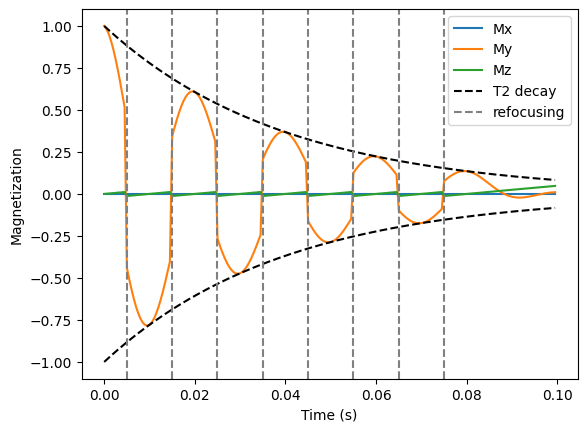

In [30]:
# plot each average

plt.figure()
plt.plot(TR_vec[0], M_avg_echo[0,:], label='Mx')
plt.plot(TR_vec[0], M_avg_echo[1,:], label='My')
plt.plot(TR_vec[0], M_avg_echo[2,:], label='Mz')
plt.plot(TR_vec[0],np.exp(-TR_vec[0]/T2), label='T2 decay', linestyle='dashed', color = "black")
plt.plot(TR_vec[0],-np.exp(-TR_vec[0]/T2), linestyle='dashed', color = "black")
plt.axvline(TE/2, linestyle = "dashed", color = "grey")
plt.axvline(3*TE/2, linestyle = "dashed", color = "grey")
plt.axvline(5*TE/2, linestyle = "dashed", color = "grey")
plt.axvline(7*TE/2, linestyle = "dashed", color = "grey")
plt.axvline(9*TE/2, linestyle = "dashed", color = "grey")
plt.axvline(11*TE/2, linestyle = "dashed", color = "grey")
plt.axvline(13*TE/2, linestyle = "dashed", color = "grey")
plt.axvline(15*TE/2, linestyle = "dashed", color = "grey" , label = "refocusing")
plt.legend(loc='upper right')
plt.xlabel("Time (s)")
plt.ylabel("Magnetization")

plt.show()

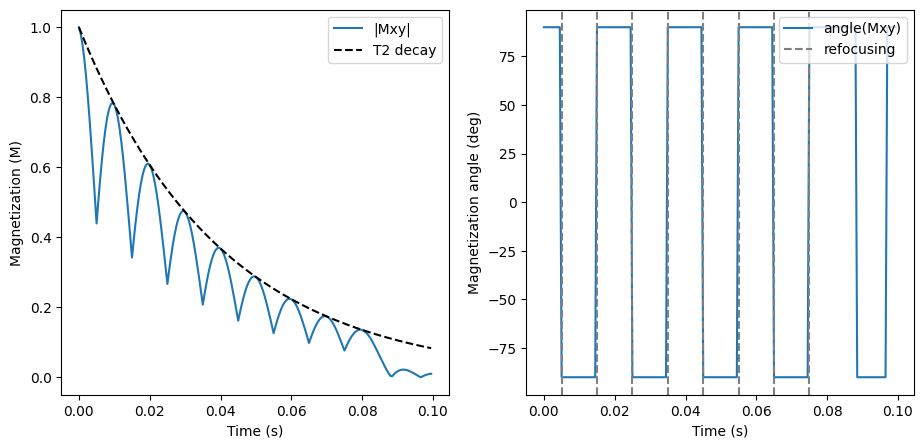

In [31]:
# transverse magnetization 

M_xy_avg_echo = M_avg_echo[0,:] + 1j*M_avg_echo[1,:]



# plot angle and magnitude in function of time

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))
ax1.plot(TR_vec[0], np.abs(M_xy_avg_echo), label='|Mxy|')
ax1.plot(TR_vec[0],np.exp(-TR_vec[0]/T2), label='T2 decay', linestyle='dashed', color = "black")
ax1.set_ylabel("Magnetization (M)")
ax1.set_xlabel("Time (s)")
ax1.legend(loc='upper right')


ax2.plot(TR_vec[0], np.angle(M_xy_avg_echo)*(180/np.pi), label='angle(Mxy)')
ax2.set_ylabel("Magnetization angle (deg)")
ax2.set_xlabel("Time (s)")
ax2.axvline(TE/2, linestyle = "dashed", color = "grey")
ax2.axvline(3*TE/2, linestyle = "dashed", color = "grey")
ax2.axvline(5*TE/2, linestyle = "dashed", color = "grey")
ax2.axvline(7*TE/2, linestyle = "dashed", color = "grey")
ax2.axvline(9*TE/2, linestyle = "dashed", color = "grey")
ax2.axvline(11*TE/2, linestyle = "dashed", color = "grey")
ax2.axvline(13*TE/2, linestyle = "dashed", color = "grey")
ax2.axvline(15*TE/2, linestyle = "dashed", color = "grey" , label = "refocusing")
ax2.legend(loc='upper right')
plt.show()

The 180 degree rephocusing pulse synchs the proton procession, which was previously dephasing generating a loss of signal.

The signal enveloppe joining maximums of echos after 180° RF pulses is corresponding to the pure T2 decay curve.

In [32]:
M_nTE = np.zeros(9)

for i in range(9):
    #print(int(((TE*i)/step)))
    #print(M_avg_echo[1,int(((TE*i)/step))])
    M_nTE[i] = M_avg_echo[1,int(((TE*i)/step))]

print(M_nTE)

#M_nTE_test = [M_avg_echo[1,20],M_avg_echo[2,20],M_avg_echo[2,40],M_avg_echo[2,60],M_avg_echo[2,80],M_avg_echo[2,100],M_avg_echo[2,120],M_avg_echo[2,140]]
#print(M_nTE_test)

[ 1.         -0.77880078  0.60653066 -0.47236655  0.36787944 -0.2865048
  0.22313016 -0.17377394  0.13533528]


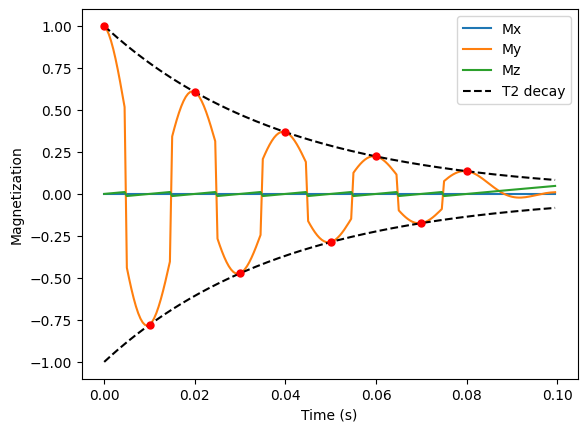

In [33]:
# plot each average

plt.figure()
plt.plot(TR_vec[0], M_avg_echo[0,:], label='Mx')
plt.plot(TR_vec[0], M_avg_echo[1,:], label='My')
plt.plot(TR_vec[0], M_avg_echo[2,:], label='Mz')
plt.plot(TR_vec[0],np.exp(-TR_vec[0]/T2), label='T2 decay', linestyle='dashed', color = "black")
plt.plot(TR_vec[0],-np.exp(-TR_vec[0]/T2), linestyle='dashed', color = "black")
plt.plot(0, M_nTE[0], 'o', color = "red",markersize = 5)
plt.plot(TE, M_nTE[1], 'o', color = "red",markersize = 5)
plt.plot(2*TE, M_nTE[2], 'o', color = "red",markersize = 5)
plt.plot(3*TE, M_nTE[3], 'o', color = "red",markersize = 5)
plt.plot(4*TE, M_nTE[4], 'o', color = "red",markersize = 5)
plt.plot(5*TE, M_nTE[5], 'o', color = "red",markersize = 5)
plt.plot(6*TE, M_nTE[6], 'o', color = "red",markersize = 5)
plt.plot(7*TE, M_nTE[7], 'o', color = "red", markersize = 5)
plt.plot(8*TE, M_nTE[8], 'o', color = "red", markersize = 5)
plt.legend(loc='upper right')
plt.xlabel("Time (s)")
plt.ylabel("Magnetization")

plt.show()

In [34]:
# fit exponential to M_nTE

x = np.arange(10,100,10)*10**-3
#print(x)
p = np.polyfit(x, np.log(abs(M_nTE)), 1)
#print(p)
print("T2 = ", -1/p[0], "s") # supostamente seria so isto mas n esta a dar nada de jeito
real_T2 = -1/p[0]

T2 =  0.04000000000000004 s


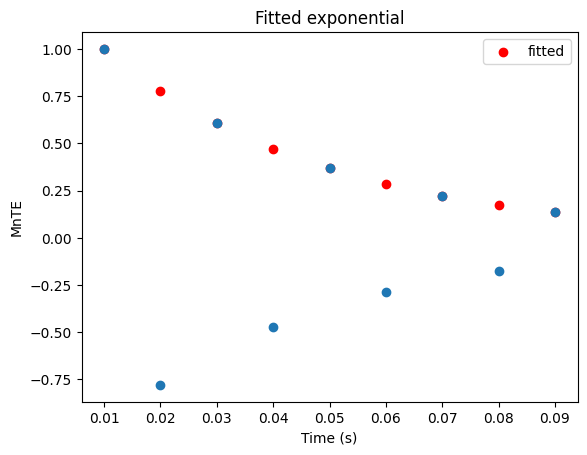

In [35]:
# fit exponential to M_nTE

x = np.arange(10,100,10)*10**-3
p = np.polyfit(x, np.log(abs(M_nTE)), 1)
a = p[1]
b = p[0]
y_fitted = np.exp(a) * np.exp(b*x)
ax = plt.axes()
ax.scatter(x, y_fitted, color='red', label='fitted')
ax.scatter(x, M_nTE)
ax.set_title('Fitted exponential')
ax.set_xlabel('Time (s)')
ax.set_ylabel('MnTE')
ax.legend()
plt.show()

In [36]:
# difference between experimental and theoretical T2

print("T2 difference = ", abs(real_T2-T2), "s")


T2 difference =  4.163336342344337e-17 s


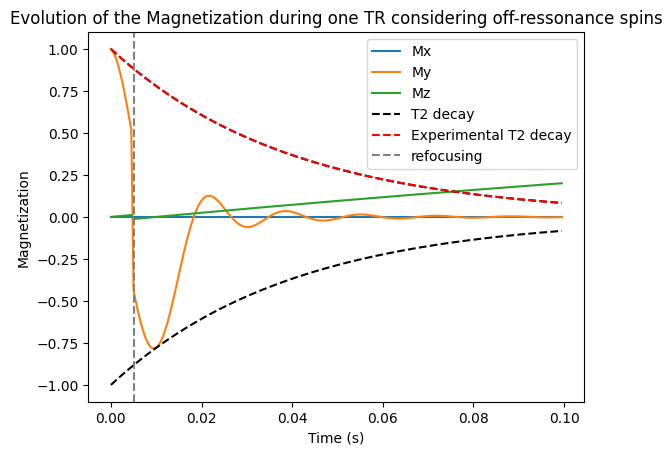

In [37]:
plt.figure()
plt.plot(TR_vec[0], M_avg[0,:], label='Mx')
plt.plot(TR_vec[0], M_avg[1,:], label='My')
plt.plot(TR_vec[0], M_avg[2,:], label='Mz')
plt.plot(TR_vec[0],np.exp(-TR_vec[0]/T2), label='T2 decay', linestyle='dashed', color = "black")
plt.plot(TR_vec[0],-1*np.exp(-TR_vec[0]/T2), linestyle='dashed', color = "black")
plt.plot(TR_vec[0],np.exp(-TR_vec[0]/real_T2), label='Experimental T2 decay', linestyle='dashed', color = "red")
plt.xlabel("Time (s)")
plt.ylabel("Magnetization")
plt.title("Evolution of the Magnetization during one TR considering off-ressonance spins")
plt.axvline(TE/2, linestyle = "dashed", color = "grey", label = "refocusing")
plt.ylim([-1.10, 1.10])
plt.legend(loc='upper right')
plt.show()

The spin-echo can only refocus spins that had phase dispersion due to a static field inhomogeneity (T2* processes).

It cannot refocus spins that have experiences a time varying B0 field, i.e, phase dispersion due to diffusion and T2 processes.

For this reason, at time TE (Echo Time), the signal is not as high as the initial transverse magnetization intensity. 

The signal intensity depends on the time constants, which depend on the medium (structure of the tissue etc), which explains the MRI contrast.

What if we wanted to calculate T1? Inversion-recovery sequence!

Consists of a series of 90 deg excitations PRECEDED by 180 deg inversions at an inversion time TI, separeted by TR and followed by signal acquisiton. A formula analogous to the one used to calculate T2 can be drawn from this experiment to calculate T1.
